<a href="https://colab.research.google.com/github/LiyaGZ/Portfolio/blob/main/%D0%90%D0%92_%D1%82%D0%B5%D1%81%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A5%D0%B8_%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82_Bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***A/B-тестирование на реальном датасете (методы Хи-квадрат и Bootstrap)***

## Формулировка гипотезы

Hо: p(a) = p(b)

H1: p(a) ≠ p(b)

где p(a) и p(b) означают соответственно коэффициент конверсии старого и нового дизайна. 

## Набор данных

In [ ]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# загрузим датасет в виде датафрейма
data = pd.read_csv('ab_data.csv', index_col = 0)

In [ ]:
data.head()

,user_id,test_group,created_order_in_3_days,order_sum,geo_group,marketing_group
39152,1005040,control,1,5194.269328,msk,target_direct
19680,1069723,test,0,NaN,msk,target_direct
6738,1064653,test,0,NaN,msk,target_direct
12480,1063744,test,1,18940.000000,msk,organic
6626,1022929,control,0,NaN,spb,social_media


В колонке created_order_in_3_days:
- 0 - для пользователей, которые ничего не купили в течение 3 дней
- 1 - для тех, кто совершил покупку в отведенное окно конверсии

order_sum - сумма покупки пользователя

geo_group - географическое положение пользователя

marketing_group - маркетинговый канал привлечения: платный трафик, соцсети, органический, рекламная акция

В колонке test_group у каждого пользователя проставлен статус: был он в тестовой группе или в контрольной

Посчитаем для каждой группы:
- количество пользователей 'user_id': 'count'
- сумма единиц - количество пользователей, которые совершили покупку в течение 3 дней 'created_order_in_3_days': 'sum'

И добавим новый столбец с конверсией в обеих группах. Количество купивших разделим на общее количество в группе.

In [ ]:
metrics = data.groupby('test_group', as_index = False).agg({'user_id': 'count', 'created_order_in_3_days': 'sum'})
metrics['conversion'] = round(metrics['created_order_in_3_days']/metrics['user_id']*100, 2)
metrics

,test_group,user_id,created_order_in_3_days,conversion
0,control,5062,1594,31.49
1,test,4938,1583,32.06


##Необходимо убедиться, что пользователи в каждой группе распределены равномерно по сегментам geo_group и marketing_group

Мы хотим быстро посмотреть распределение сегментов в обеих группах. Для этого напишем функцию, которая строит столбчатую диаграмму по сегментам для каждой группы.
- по оси Х график выводит сегмент, который мы передадим
- по оси У график выводит количество пользователей
- в данных мы сгруппируем количество пользователей по тестовой и контрольной группам

In [ ]:
def plot_segments_distribution(df, segment_columns, test_factor):
    for segment in segment_columns:
        aggregated_data = df.groupby(by = [test_factor, segment])['user_id'].count().reset_index()
        sns.catplot (x = segment, 
                     y = 'user_id',
                     hue = test_factor, # сообщаем, что хотим, чтобы разные группы имели разный цвет
                     data = aggregated_data,
                     kind = 'bar',
                     height = 4, # задаем размер графика
                     aspect = 1.5) # задаем ширину столбца    

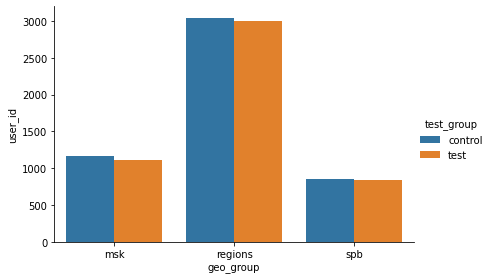

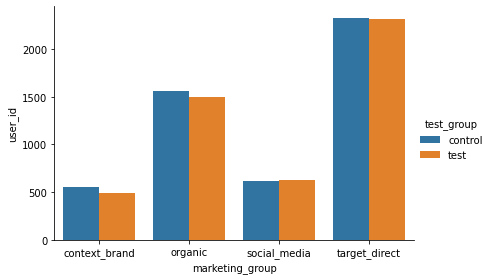

In [ ]:
# вызовем функцию и построим графики распределения по сегментам:
plot_segments_distribution(data, ['geo_group','marketing_group'], 'test_group')

##Используем критерий Хи-квадрат для конверсии

Мы поняли, что собранные данные правильно распределены по сегментам. Теперь пришло время оценить, насколько разница в конверсии, которую мы получили на собранных данных, статистически значима. То есть, можем ли мы быть уверены, что разница, которую мы наблюдаем - неслучайна.

Для такого анализа используют статистические критерии.
Они бывают разными для разных данных.

Хи-квадрат - критерий, который подходит для оценки конверсии, поскольку данные конверсии - дискретные: пользователь либо совершил покупку, и мы присвоили ему 1, либо не совершил, и мы присвоили ему 0.

Функция, которая нам нужна, чтобы использовать Хи-квадрат, есть в библиотеке statsmodels. Мы импортируем из нее объект stats.proportion, который позволяет считать пропорции.

In [ ]:
import statsmodels.stats.proportion as proportion

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Статистический критерий вернет нам значение p-value, которое поможет оценить: есть ли статистическая значимость в разнице конверсий, которую показывает наш эксперимент.

##Посчитаем p-value

Передаем функции proportions_chisquare() параметры:
1) количество покупок в наших группах - значения колонки 'created_order_in_3_days'
2) количество наблюдений - всех пользователей из колонки 'user_id'

Так как функция возвращает 3 значения, мы сразу создадим 3 переменные через запятую:
- chi2stat - статистика под капотом критерия
- pval - интересующее нас значение p-value
- table - таблица сопряженности: она помогает исследовать связи в распределениях, но в данной задаче она нам не понадобится


In [ ]:
chi2stat, pval, table = proportion.proportions_chisquare(metrics['created_order_in_3_days'], metrics['user_id'])

Так как ни один статистический критерий не дает 100% уверенности, мы зададим ему порог 5% для ошибки первого рода - то есть согласимся, что 5% наших наблюдений будут ошибочными.

In [ ]:
alpha = 0.05

p-value - это фактическая вероятность попасть в ошибку первого рода на наших данных, если мы отклоним нулевую гипотезу. **Сравним p-value с желаемым уровнем точности нашего эксперимента.**

- Если **p-value меньше** порога ошибки первого рода - результат эксперимента можно считать статзначимым.
- Если **p-value больше** - мы будем вынуждены признать разницу в значениях контрольной и тестовой группы случайной

In [ ]:
print(pval < alpha)

False


**Статистически значимой разницы в конверсии не обнаружено, т.к. p-value выше выбранного порога ошибки первого рода.** 

## Используем Bootstrap для среднего чека

Прежде чем делать выводы, проверим, нет ли значимого изменения среднего чека, ведь конверсия и средний чек - это метрики, которые тесно связаны: если улучшить одну, другая может стать хуже.

Для среднего чека не подходит Хи-квадрат, т.к. эта метрика не дискретная: у среднего чека большой разброс значений на разных пользователей, которые редко распределены нормально. Поэтому Т-тест тоже не подходит.

Здесь поможет метод ***Bootstrap***.

Он уже реализован в библиотеке bootstrapped - скачаем ее:

In [ ]:
# скачиваем библиотеку с помощью !pip
!pip install bootstrapped

  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13954 sha256=359e4a72ec54f921a605cacbef1c480f970ddeed69b5713622ed48fff04a9421
  Stored in directory: /root/.cache/pip/wheels/15/55/6a/9a722f067ac4c3dfab359ed2ec7906b9cc6649156d9886bd59
Successfully built bootstrapped


In [ ]:
# импортируем необходимые модули
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

***Нам понадобится функция bootstrap_ab. Чтобы подготовить данные, давайте посмотрим, какие аргументы она принимает:***



Первый аргумент - test - массив с данными тестовой группы.

Наши данные в датафрейме data не подходят, т.к. в них тестовая и контрольная группы вместе. Кроме того, есть пользователи без покупок - их не нужно учитывать в подсчете среднего чека.

- Отделим только пользователей из тестовой группы.
- Удалим пустые значения, т.е. пользователей, не сделавших покупку.
- Метод .values превратит серию в массив.

*Массив - это структура данных, которая похожа на списки. Но в отличие от них массивы хранят только данные одного типа. Например, только строки или только числовые данные.*

In [ ]:
test = data[data['test_group'] == 'test']['order_sum'].dropna().values

Второй аргумент - ctrl - массив с данными контрольной группы.

- Отделим только пользователей из контрольной группы.
- Удалим пустые значения, т.е. пользователей, не сделавших покупку.
- Метод .values превратит серию в массив. 

In [ ]:
ctrl = data[data['test_group'] == 'control']['order_sum'].dropna().values

Также нам понадобятся аргументы:
- stat_func = bs_stats.mean - что мы хотим исследовать. В нашем случае - среднее значение
- compare_func = bs_compare.difference - как мы хотим исследовать. В нашем случае - хотим взять разницу между группами
- return_distribution = True - вернем набор разниц, который функция получает в результате всех итераций

Чтобы сохранить то, что возвращает функция, запишем результат ее работы в переменную boot_results.



In [ ]:
boot_results = bs.bootstrap_ab(test = test, ctrl = ctrl, 
                               stat_func = bs_stats.mean,
                               compare_func = bs_compare.difference,
                               return_distribution = True)

Мы получили массив разниц в средних чеках между нашими группами.

In [ ]:
boot_results

array([431.54013338, 102.40255947, 295.14238175, ..., 222.41022605,
       411.72174583, 234.86645106])

##Доверительный интервал

Значение среднего чека, которое мы получили для обеих групп, верно только для тех групп пользователей, которые пришли в течение эксперимента. Если бы в эксперименте участвовали похожие, но другие пользователи - значение среднего чека немного, но отличалось бы. Понять, насколько могут отличаться похожие группы в нашем эксперименте, поможет доверительный интервал.

Уровень доверия обычно устанавливают в 95%. То есть можно сказать, что в 95% аналогичных экспериментов конверсия будет колебаться внутри этого интервала.

**Зададим границы доверительного интервала от 2,5 до 97,5 - между ними как раз 95%.**

In [ ]:
borders = np.percentile(boot_results, [2.5, 97.5])   # считаем персентили
borders

array([-123.43103288,  496.08423168])

Используем полученный выше массив в переменной boot_results, чтобы выяснить доверительный интервал - то есть тот интервал колебаний среднего чека похожих экспериментов.

Если ноль не входит в доверительный интервал, аналогично условию p_value < alpha, - разница значима.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


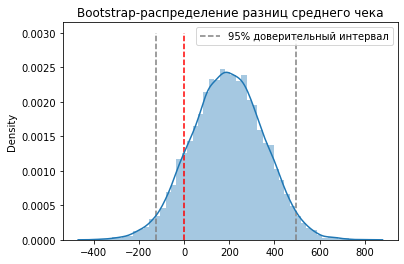

In [ ]:
sns.distplot(boot_results)   # функция построения распределения
plt.title('Bootstrap-распределение разниц среднего чека')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0,   # отрисуем линию на уровне ноля
           ymin = 0,
           ymax = 0.003,
           linestyles = '--',
           colors = 'red')
plt.vlines(borders,   # отрисуем персентили
           ymin = 0,
           ymax = 0.003,
           linestyles = '--',
           colors = 'grey',
           label = '95% доверительный интервал')
plt.legend()
plt.show()

##Результат

Статистически значимой разницы в среднем чеке не обнаружено, т.к. 0 входит в доверительный интервал разницы между группами.